In [1]:
import pandas as pd
import numpy as np

policy_name = '$0: 0.500000, $1: 0.418000, $20: 0.080000, $80: 0.002000'

df_dict = {}

# Read the CSV file
df_dict[r'$(\vec{p}_{CTN-0007}, \vec{d}_{linear})$ (CTN-0007)'] = pd.read_csv('linear.csv')
df_dict[r'$(\vec{p}_{CTN-0007}, \vec{d}_{log})$'] = pd.read_csv('logarithmic.csv')
df_dict[r'$(\vec{p}_{CTN-0007}, \vec{d}_{logistic})$'] = pd.read_csv('logistic.csv')

for escalation_rule in df_dict.keys():
    df_dict[escalation_rule] = df_dict[escalation_rule][df_dict[escalation_rule]['policy']
                                                        ==policy_name]
    del(escalation_rule)

/tmp/ipykernel_20340/1025144759.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


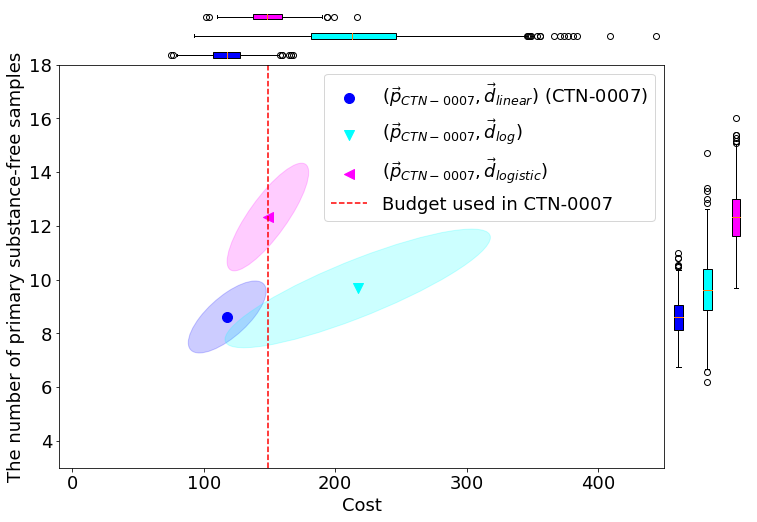

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Ensure Matplotlib does not use LaTeX
plt.rcParams['text.usetex'] = False

def plot_ellipse(ax, x, y, label, color, marker):
    """
    Plot an ellipse based on the means and covariances of x and y data.
    """
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*2*1.96, height=lambda_[1]*2*1.96, # 1.96 corresponds to 95% CI for normal distribution
                  angle=np.rad2deg(np.arccos(v[0, 0])), color=color, alpha=0.2)
    ax.add_patch(ell)
    ax.scatter(np.mean(x), np.mean(y), color=color, s=100, label=label, marker=marker)

# Setting up the main plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])  # x-position, y-position, width, height

# Data for box plots
data_incentives = []
data_outcomes = []

colors = {
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{linear})$ (CTN-0007)': 'blue',
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{log})$': 'cyan',
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{logistic})$': 'magenta'
}

markers = {
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{linear})$ (CTN-0007)': 'o',
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{log})$': 'v',
    r'$(\vec{p}_{CTN-0007}, \vec{d}_{logistic})$': '<'
}

# Looping through each escalation rule to plot the ellipse and gather data for boxplots
for escalation_rule, color in zip(df_dict.keys(), colors):
    incentives_data = df_dict[escalation_rule][df_dict[escalation_rule]['reward name']
                                               == 'incentives']['discounted reward'].values
    outcome_data = df_dict[escalation_rule][df_dict[escalation_rule]['reward name']
                                            == 'primary substance-free']['discounted reward'].values
    plot_ellipse(ax, incentives_data, outcome_data, escalation_rule,
                 colors[escalation_rule], markers[escalation_rule])
    
    data_incentives.append(incentives_data)
    data_outcomes.append(outcome_data)

# Calculate the range of all incentive and outcome data values
all_incentives = np.concatenate(data_incentives)
all_outcomes = np.concatenate(data_outcomes)

buffer_percentage = 0.05
xmin = np.min(all_incentives) - buffer_percentage * np.ptp(all_incentives)
xmax = np.max(all_incentives) + buffer_percentage * np.ptp(all_incentives)
ymin = np.min(all_outcomes) - buffer_percentage * np.ptp(all_outcomes)
ymax = np.max(all_outcomes) + buffer_percentage * np.ptp(all_outcomes)

# Set the adjusted xlim and ylim to the main scatter plot
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Creating the boxplots on x-axis
ax_xbox = fig.add_axes([0.1, 0.8, 0.7, 0.1])
bp_x = ax_xbox.boxplot(data_incentives, vert=False, patch_artist=True, positions=[1, 2, 3])  # Added positions
ax_xbox.set_xlim(xmin, xmax)  # Set xlim of ax_xbox to match scatter plot's xlim
ax_xbox.axis('off')
for patch, color in zip(bp_x['boxes'], colors.values()):
    patch.set_facecolor(color)

# Creating the boxplots on y-axis
ax_ybox = fig.add_axes([0.8, 0.1, 0.1, 0.7])
bp_y = ax_ybox.boxplot(data_outcomes, patch_artist=True, positions=[1, 2, 3])  # Added positions
ax_ybox.set_ylim(ymin, ymax)  # Set ylim of ax_ybox to match scatter plot's ylim
ax_ybox.axis('off')
for patch, color in zip(bp_y['boxes'], colors.values()):
    patch.set_facecolor(color)

# Setting up the main plot details
ax.axvline(x=149, color='red', linestyle='--', linewidth=1.5, label='Budget used in CTN-0007')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.set_xlim(-10, 450)
ax.set_ylim(3, 18)
ax_xbox.set_xlim(-10, 450)
ax_ybox.set_ylim(3, 18)

ax.set_xlabel('Cost', fontsize=18)
ax.set_ylabel('The number of primary substance-free samples', fontsize=18)
plt.tight_layout()
ax.legend(fontsize=18, loc='best')

plt.savefig("expected_price_vs_treatment_outcome_escalation.jpg", dpi=300, bbox_inches='tight')
plt.show()
